In [1]:
import os
import cv2
import sys
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch import optim
#from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import sm_ViT_Model

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'
device 

'cpu'

In [ ]:
def model_summary():
  model = sm_ViT_Model.ViTGenerator().to(device)
  summary(model, (1,1000,1000))
model_summary()

Load Data

In [2]:
class Data(Dataset):
  def __init__(self):
    self.diff_grid = torch.tensor(np.load('../dataset/small/sm_diff_grid.npz')['arr_0']).float()
    labels = np.load('../dataset/small/sm_diffraction_label.npz')['arr_0']
    self.phase = torch.tensor(labels[:, 0]).float()
    self.amp = torch.tensor(labels[:, 1]).float()
  def __len__(self):
    return self.diff_grid.shape[0]
  def __getitem__(self, i):
    return (self.diff_grid[i], self.phase[i], self.amp[i])

In [3]:
trn_ds = Data()
trn_dl = DataLoader(trn_ds, batch_size=4, shuffle=True)

In [4]:
lossfn =  nn.BCELoss(reduction='mean')

def ModelLoss(preds1, targets1, preds2, targets2):
  loss1 = lossfn(preds1, targets1)
  loss2 = lossfn(preds2, targets2)
  return loss1, loss2

In [5]:
ViTModel = sm_ViT_Model.ViTGenerator().to(device)
LR = 0.003
step_size = 8000
criterion = lossfn

optimizer = optim.AdamW(ViTModel.parameters(), lr=LR, betas=(0.59418, 0.8699))
scheduler = optim.lr_scheduler.CyclicLR(optimizer, base_lr=LR/10, max_lr=LR, step_size_up=step_size, cycle_momentum=False, mode='triangular2')

In [10]:
num_epochs = 100

for epoch in range(num_epochs):
  for bx, data in enumerate(trn_dl):
    diff, phase, amp = data
    diff, phase, amp = diff.to(device), phase.to(device), amp.to(device)
    
    ViTModel.train()
    phase_pred, amp_pred = ViTModel(diff)
    
    loss1, loss2 = ModelLoss(phase_pred, phase, amp_pred, amp)
    loss = loss1 + loss2
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()

    if((epoch+1) % 1 == 0):
      print("Epoch: ", (epoch+1), " Training Loss: ", round(loss.item(), 10), " L1: ",round(loss1.item(), 8)," L2: ", round(loss2.item(), 8))


#torch.save(ViTModel.state_dict(), 'models/model_name.pth')

Epoch:  1  Training Loss:  1.4462354183  L1:  0.75926125  L2:  0.68697411
Epoch:  2  Training Loss:  1.4457840919  L1:  0.7588408  L2:  0.68694329
Epoch:  3  Training Loss:  1.4455151558  L1:  0.75860262  L2:  0.68691254
Epoch:  4  Training Loss:  1.4454991817  L1:  0.75861824  L2:  0.68688101
Epoch:  5  Training Loss:  1.4451806545  L1:  0.75833201  L2:  0.68684858
Epoch:  6  Training Loss:  1.4448726177  L1:  0.75805342  L2:  0.6868192
Epoch:  7  Training Loss:  1.444852829  L1:  0.75805974  L2:  0.68679303
Epoch:  8  Training Loss:  1.4446172714  L1:  0.75784957  L2:  0.68676764
Epoch:  9  Training Loss:  1.4441969395  L1:  0.75745881  L2:  0.68673813
Epoch:  10  Training Loss:  1.4440859556  L1:  0.75737298  L2:  0.68671298
Epoch:  11  Training Loss:  1.4441626072  L1:  0.7574724  L2:  0.68669021
Epoch:  12  Training Loss:  1.4438505173  L1:  0.75719011  L2:  0.68666041
Epoch:  13  Training Loss:  1.4434095621  L1:  0.75677764  L2:  0.68663192
Epoch:  14  Training Loss:  1.44335258

In [8]:
diff_grid = np.load('../dataset/small/sm_diff_grid.npz')['arr_0']
label = np.load('../dataset/small/sm_diffraction_label.npz')['arr_0']
diff = torch.tensor(diff_grid,device=device).float()
phase = torch.tensor(label[:, 0],device=device).float()
amp = torch.tensor(label[:, 1],device=device).float()
ViTModel.eval()
phase_pred, amp_pred = ViTModel(diff)

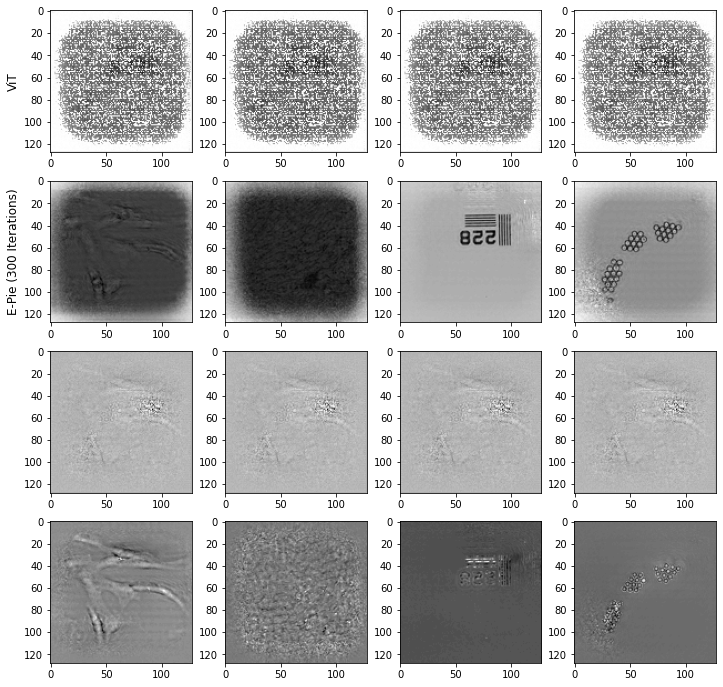

In [11]:
f, ax = plt.subplots(4,4, figsize=(12, 12), facecolor='white')
ax[0,0].set_ylabel('ViT', fontsize = 12.0)
ax[1,0].set_ylabel('E-Pie (300 Iterations)', fontsize = 12.0)

ax[0,0].imshow(phase_pred[0].cpu().detach().numpy().reshape((128,128)), cmap='gray')
ax[0,1].imshow(phase_pred[1].cpu().detach().numpy().reshape((128,128)), cmap='gray')
ax[0,2].imshow(phase_pred[2].cpu().detach().numpy().reshape((128,128)), cmap='gray')
ax[0,3].imshow(phase_pred[3].cpu().detach().numpy().reshape((128,128)), cmap='gray')
ax[1,0].imshow(phase[0].cpu().detach().numpy().reshape((128,128)), cmap='gray')
ax[1,1].imshow(phase[1].cpu().detach().numpy().reshape((128,128)), cmap='gray')
ax[1,2].imshow(phase[2].cpu().detach().numpy().reshape((128,128)), cmap='gray')
ax[1,3].imshow(phase[3].cpu().detach().numpy().reshape((128,128)), cmap='gray')
ax[2,0].imshow(amp_pred[0].cpu().detach().numpy().reshape((128,128)), cmap='gray')
ax[2,1].imshow(amp_pred[1].cpu().detach().numpy().reshape((128,128)), cmap='gray')
ax[2,2].imshow(amp_pred[2].cpu().detach().numpy().reshape((128,128)), cmap='gray')
ax[2,3].imshow(amp_pred[3].cpu().detach().numpy().reshape((128,128)), cmap='gray')
ax[3,0].imshow(amp[0].cpu().detach().numpy().reshape((128,128)), cmap='gray')
ax[3,1].imshow(amp[1].cpu().detach().numpy().reshape((128,128)), cmap='gray')
ax[3,2].imshow(amp[2].cpu().detach().numpy().reshape((128,128)), cmap='gray')
ax[3,3].imshow(amp[3].cpu().detach().numpy().reshape((128,128)), cmap='gray')